<a href="https://colab.research.google.com/github/Ssalgia/Music-Genre-Prediction-Using-Neural/blob/master/GenereClassifiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data processing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import json
import os
import math
import librosa
 
DATASET_PATH = "/content/gdrive/My Drive/genres"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
 
 
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """
 
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
 
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
 
    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
 
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:
 
            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
 
            # process all audio files in genre sub-dir
            for f in filenames:
 
        # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
 
                # process all segments of audio file
                for d in range(num_segments):
 
                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
 
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
 
                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))
 
    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/genres/hiphop/hiphop.00006.wav, segment:7
/content/gdrive/My Drive/genres/hiphop/hiphop.00006.wav, segment:8
/content/gdrive/My Drive/genres/hiphop/hiphop.00006.wav, segment:9
/content/gdrive/My Drive/genres/hiphop/hiphop.00006.wav, segment:10
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:1
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:2
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:3
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:4
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:5
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:6
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:7
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:8
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:9
/content/gdrive/My Drive/genres/hiphop/hiphop.00001.wav, segment:10
/content/

# CNN build up and saving

(130, 13, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 1

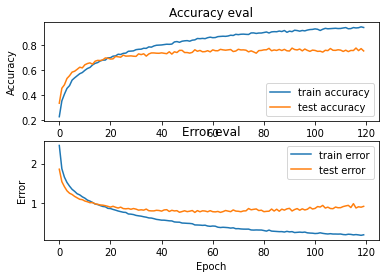

79/79 - 1s - loss: 0.9396 - accuracy: 0.7299

Test accuracy: 0.7298919558525085
Target: 7, Predicted label: [1]
Saved model to disk
INFO:tensorflow:Assets written to: pre.model/assets


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
 
DATA_PATH = "data_10.json"
 
 
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """
 
    with open(data_path, "r") as fp:
        data = json.load(fp)
 
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y
 
 
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """
 
    fig, axs = plt.subplots(2)
 
    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
 
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
 
    plt.show()
 
 
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """
 
    # load data
    X, y = load_data(DATA_PATH)
 
    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
 
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
 
    return X_train, X_validation, X_test, y_train, y_validation, y_test
 
 
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """
 
    # build network topology
    model = keras.Sequential()
 
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
 
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
 
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
 
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
 
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
 
    return model
 
 
def predict1(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """
 
    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
 
    # perform prediction
    prediction = model.predict(X)
 
    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
 
    print("Target: {}, Predicted label: {}".format(y, predicted_index))
 
 
if __name__ == "__main__":
 
    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
 
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    print(input_shape)
    model = build_model(input_shape)
 
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
 
    model.summary()
 
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=120)
 
    # plot accuracy/error for training and validation
    plot_history(history)
 
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
 
   # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]
 
    # predict sample
    predict1(model, X_to_predict, y_to_predict)
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")  
model.save("pre.model")

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
import json
import os
import math
import librosa
 
DATASET_PATH = "/content/gdrive/My Drive/input"
JSON_PATH = "input.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
 
 
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """
 
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
 
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
 
    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
 
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:
 
            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
 
            # process all audio files in genre sub-dir
            for f in filenames:
 
        # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
 
                # process all segments of audio file
                for d in range(num_segments):
 
                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
 
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
 
                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))
 
    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: input
/content/gdrive/My Drive/input/input/numb.wav, segment:1
/content/gdrive/My Drive/input/input/numb.wav, segment:2
/content/gdrive/My Drive/input/input/numb.wav, segment:3
/content/gdrive/My Drive/input/input/numb.wav, segment:4
/content/gdrive/My Drive/input/input/numb.wav, segment:5
/content/gdrive/My Drive/input/input/numb.wav, segment:6
/content/gdrive/My Drive/input/input/numb.wav, segment:7
/content/gdrive/My Drive/input/input/numb.wav, segment:8
/content/gdrive/My Drive/input/input/numb.wav, segment:9
/content/gdrive/My Drive/input/input/numb.wav, segment:10


input

In [ ]:
import json
import wave
import tensorflow as tf
import os
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import matplotlib.pyplot as plt

Genre_names = np.array(['jazz','raggae', 'country','disco','blues','hiphop','metal','pop','rock','classical','del','space','nothing'])

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
loaded_model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

testing = load_data("./input.json")
print(testing[0].shape)
testing1 = testing[0][... ,np.newaxis]
print(testing1.shape)
prediction = model.predict(testing1)
predicted_index = np.argmax(prediction, axis=1)
print("Predicted label: {}".format( predicted_index))
print("Genre Label Predicted:")
Genre = np.bincount(predicted_index).argmax()
print(np.bincount(predicted_index).argmax())
ans = Genre_names.flat[Genre]
print(ans)

Loaded model from disk
79/79 - 1s - loss: 0.9396 - accuracy: 0.7299
accuracy: 72.99%
(10, 130, 13)
(10, 130, 13, 1)
Predicted label: [8 8 3 8 8 8 8 8 8 8]
Genre Label Predicted:
8
rock
